In [1]:
import os
try:
    from google.colab import drive
    drive.mount("/content/gdrive", force_remount=True)
    # cd gdrive/MyDrive/'Colab Notebooks'/Innovative-Approaches-to-Asset-Prediction/
    os.chdir("/content/gdrive/MyDrive/'Colab Notebooks'/Innovative-Approaches-to-Asset-Prediction/")
    print("Working on Google Colab...")
except:
    os.chdir("../")
    print("Working on local machine...")

Working on local machine...


In [2]:
# !pip install -r requirements.txt

In [3]:
import torch
import random
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
from livelossplot import PlotLosses


In [4]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled = False
    return True

In [5]:
print(torch.version.cuda)

11.7


In [6]:
set_seed(42)

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available! Using CPU!")

Cuda installed! Running on GPU!


In [7]:
# Custom dataset to handle image and target loading
class ImageDataset(Dataset):
    def __init__(self, images, targets, transform=None):
        self.images = images
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]

        if self.transform:
            image = self.transform(image)

        return image, target

In [8]:
full_data = np.load("./data/processed/SP500.EURUSD.USTREASURYINDEX.2014.2023/data.npy", allow_pickle=True)   # noqa
full_data = pd.DataFrame(full_data, columns=["Image", "Equity", "Currency", "Bond"])
full_data = full_data.head(1000)
print(full_data.shape)
print(full_data.head())
print(full_data.isna().sum())
print(full_data.dropna(inplace=True))
print(full_data.isna().sum())

(1000, 4)
                                               Image    Equity  Currency  \
0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...      -1.0  0.444672   
1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   0.79071  0.136768   
2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 255, 255, 0, 0...      -1.0  0.716276   
3  [[0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0, 0, 0...  0.633517      -1.0   
4  [[0, 0, 0, 0, 0, 0, 255, 255, 0, 0, 0, 0, 0, 0...       1.0 -0.092956   

       Bond  
0  0.555328  
1  0.072522  
2  0.283724  
3  0.366483  
4 -0.907044  
Image       0
Equity      0
Currency    0
Bond        3
dtype: int64
None
Image       0
Equity      0
Currency    0
Bond        0
dtype: int64


In [9]:
# data = full_data.head(200).to_numpy()
data = full_data.to_numpy()
print(data.shape)
# data = full_data[:500]
print(data[:1, :])

(997, 4)
[[array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8) -1.0 0.44467162365062535
  0.5553283763493746]]


In [10]:
def train_val_test_split(data, train_size=0.7, val_size=0.2):
    train_size = int(len(data) * train_size)
    val_size = int(len(data) * val_size)
    test_size = len(data) - train_size - val_size
    train_data = data[:train_size]
    val_data = data[train_size:train_size + val_size]
    test_data = data[train_size + val_size:]
    return train_data, val_data, test_data

In [11]:
train_data, val_data, test_data = train_val_test_split(data)

print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

train_images = train_data[:, 0]
train_targets = np.asarray(train_data[:, 1:], dtype=np.float32)

val_images = val_data[:, 0]
val_targets = np.asarray(val_data[:, 1:], dtype=np.float32)

test_images = test_data[:, 0]
test_targets = np.asarray(test_data[:, 1:], dtype=np.float32)

print(train_images[0])
print(train_targets[0])

(697, 4)
(199, 4)
(101, 4)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
[-1.          0.44467163  0.55532837]


In [12]:
from torchvision.transforms.functional import pad
from torchvision import transforms
from PIL import Image
import numpy as np
import numbers

def get_padding(image):    
    w, h = image.size
    max_wh = np.max([w, h])
    h_padding = (max_wh - w) / 2
    v_padding = (max_wh - h) / 2
    l_pad = h_padding if h_padding % 1 == 0 else h_padding+0.5
    t_pad = v_padding if v_padding % 1 == 0 else v_padding+0.5
    r_pad = h_padding if h_padding % 1 == 0 else h_padding-0.5
    b_pad = v_padding if v_padding % 1 == 0 else v_padding-0.5
    padding = (int(l_pad), int(t_pad), int(r_pad), int(b_pad))
    return padding

class SquarePad(object):
    def __init__(self, fill=0, padding_mode='constant'):
        assert isinstance(fill, (numbers.Number, str, tuple))
        assert padding_mode in ['constant', 'edge', 'reflect', 'symmetric']

        self.fill = fill
        self.padding_mode = padding_mode
        
    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be padded.

        Returns:
            PIL Image: Padded image.
        """
        img = Image.fromarray(img)
        return pad(img, get_padding(img), self.fill, self.padding_mode)
    
    def __repr__(self):
        return self.__class__.__name__ + '(padding={0}, fill={1}, padding_mode={2})'.\
            format(self.fill, self.padding_mode)

In [13]:
# Transformations for the images
transform = transforms.Compose([
    SquarePad(),  # Make the image square by padding
    transforms.Resize((128, 128)),  # Resize
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,)),  # Normalize to [-1, 1]
])

# Create datasets and dataloaders
trainset = ImageDataset(train_images, train_targets, transform=transform)
valset = ImageDataset(val_images, val_targets, transform=transform)
testset = ImageDataset(test_images, test_targets, transform=transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
valloader = DataLoader(valset, batch_size=16, shuffle=False)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

In [14]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

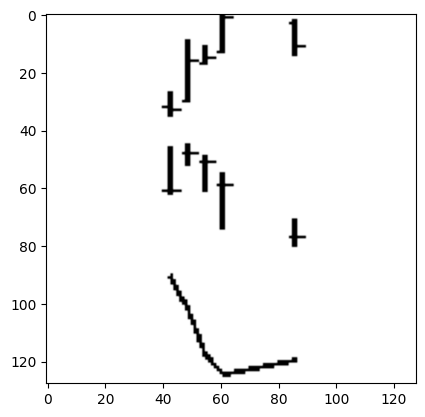

In [15]:
# get some random training images
images, labels = trainloader.dataset[0]

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

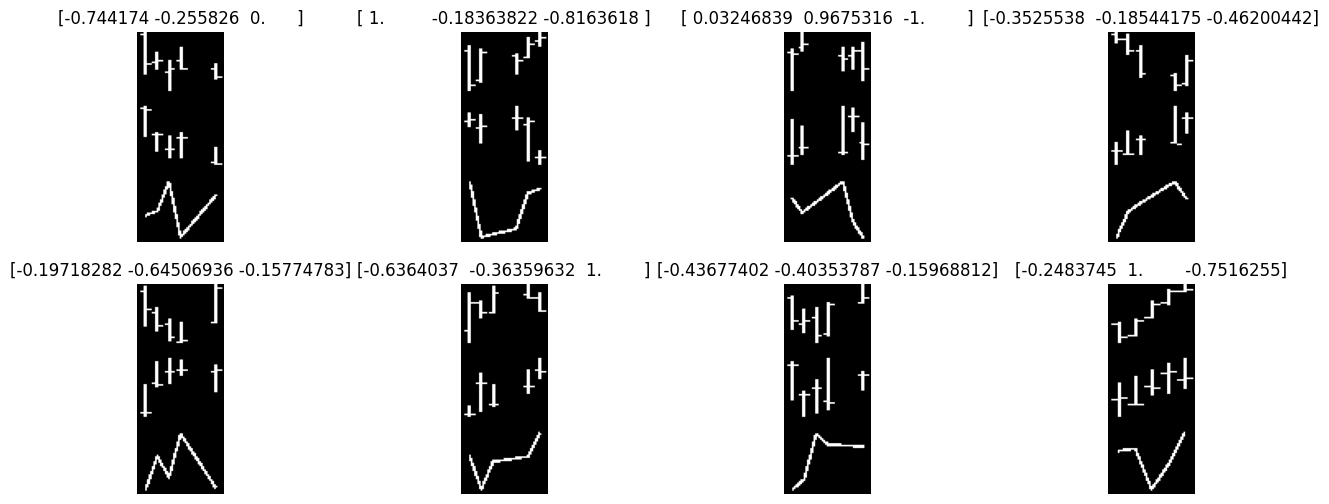

In [16]:
# helper function
def select_n_random(data, labels, n=100):
    '''
    Selects n random datapoints and their corresponding labels from a dataset
    '''
    assert len(data) == len(labels)

    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.images, trainset.targets)

# plot images
plt.figure(figsize=(16, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
plt.show()

In [17]:
class Net(nn.Module):
    def __init__(self, img_size, leak=0.9, output_size=3):
        super(Net, self).__init__()
        self.img_size = img_size

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(5, 3), padding=(2, 1))
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(5, 3), padding=(2, 1))
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(5, 3), padding=(2, 1))
        self.conv4 = nn.Conv2d(256, 512, kernel_size=(5, 3), padding=(2, 1))
        
        self.pool = nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1))
        self.leakyrelu = nn.LeakyReLU(negative_slope=leak)
        self.flatten = nn.Flatten()

        # Calculate the size of the flattened features after all convolutions and pooling layers
        self.feature_dim = self._calculate_feature_dim()
        
        # Fully connected layer
        self.fc = nn.Linear(self.feature_dim, output_size)

    def _calculate_feature_dim(self):
        with torch.no_grad():
            x = torch.randn(1, 1, *self.img_size)
            x = self.leakyrelu(self.conv1(x))
            x = self.pool(x)
            x = self.leakyrelu(self.conv2(x))
            x = self.pool(x)
            x = self.leakyrelu(self.conv3(x))
            x = self.pool(x)
            x = self.leakyrelu(self.conv4(x))
            x = self.pool(x)
            x = self.flatten(x)
            return x.shape[1]

    def forward(self, xb):
        # Convolutional layers with LeakyReLU and max-pooling
        xb = self.leakyrelu(self.conv1(xb))
        xb = self.pool(xb)
        xb = self.leakyrelu(self.conv2(xb))
        xb = self.pool(xb)
        xb = self.leakyrelu(self.conv3(xb))
        xb = self.pool(xb)
        xb = self.leakyrelu(self.conv4(xb))
        xb = self.pool(xb)
        
        # Flatten the output for the fully connected layer
        xb = self.flatten(xb)
        
        # Fully connected layer
        xb = self.fc(xb)
        
        # Apply tanh activation to output values in the range -1 to 1
        xb = torch.tanh(xb)
        return xb

In [18]:
class CustomLoss(nn.Module):
    def __init__(self, loss_function=nn.MSELoss(), alpha=1.0, l1_ratio=0.5):
        super(CustomLoss, self).__init__()
        self.element_loss = loss_function
        self.alpha = alpha
        self.l1_ratio = l1_ratio

    def forward(self, outputs, targets, model):
        # Calculate the primary loss
        loss = self.element_loss(outputs, targets)
        
        # Calculate the sum of the targets
        target_sum = torch.sum(targets, dim=1)
        
        # Calculate the penalty for how far off the sum of the elements of the outputs is from the sum of the targets
        sum_penalty = torch.mean(torch.pow(torch.sum(outputs, dim=1) - target_sum, 2))

        # Calculate L1 regularization (Lasso)
        l1_penalty = 0.0
        for param in model.parameters():
            l1_penalty += torch.sum(torch.abs(param))
        
        # Calculate L2 regularization (Ridge)
        l2_penalty = 0.0
        for param in model.parameters():
            l2_penalty += torch.sum(param ** 2)
        
        # Combine L1 and L2 regularization into ElasticNet
        elasticnet_penalty = self.alpha * (self.l1_ratio * l1_penalty + (1 - self.l1_ratio) * l2_penalty)
        
        # Combine the primary loss, sum penalty, and ElasticNet penalty
        return loss + sum_penalty + elasticnet_penalty

In [19]:
# Initialize the model, loss function, and optimizer
model = Net(img_size=(128, 128)).to(device)

# Wrap the model with DataParallel to enable multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

criterion = CustomLoss(nn.MSELoss(), alpha=0.005, l1_ratio=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.0003)

def mean_absolute_error(pred, target):
    return torch.mean(torch.abs(pred - target))

Using 2 GPUs


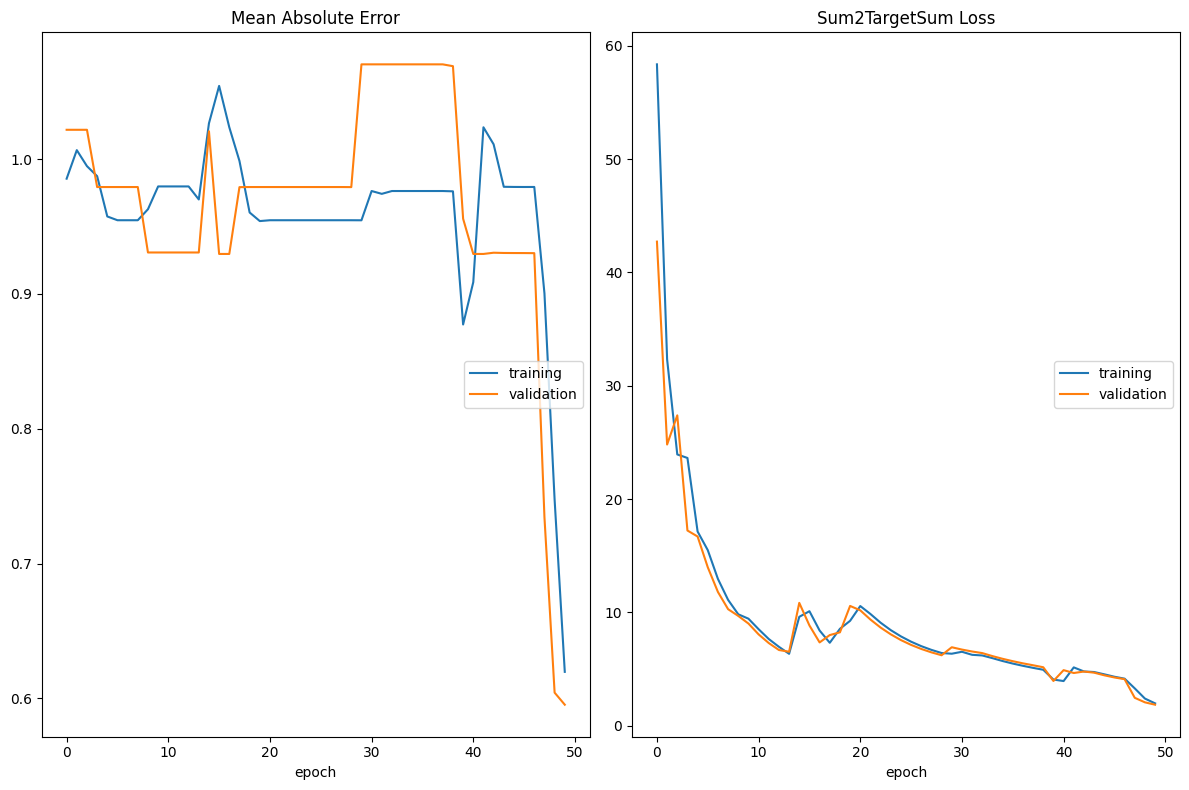

Mean Absolute Error
	training         	 (min:    0.620, max:    1.054, cur:    0.620)
	validation       	 (min:    0.595, max:    1.070, cur:    0.595)
Sum2TargetSum Loss
	training         	 (min:    1.979, max:   58.361, cur:    1.979)
	validation       	 (min:    1.860, max:   42.720, cur:    1.860)
Epoch 50/50, Train Loss: 1.9789, Train MAE: 0.6197, Validation Loss: 1.8596, Validation MAE: 0.5953
Finished Training


In [20]:
epochs = 50
best_val_loss = float('inf')
liveloss = PlotLosses()

for epoch in range(epochs):
    logs = {}
    model.train()
    running_loss = 0.0
    running_mae = 0.0

    for images, targets in trainloader:
        images, targets = images.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets, model)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        running_mae += mean_absolute_error(outputs, targets).item() * images.size(0)

    train_loss = running_loss / len(trainloader.dataset)
    train_mae = running_mae / len(trainloader.dataset)
    logs['Sum2TargetSum Loss'] = train_loss
    logs['Mean Absolute Error'] = train_mae

    # Validation
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    with torch.no_grad():
        for images, targets in valloader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            loss = criterion(outputs, targets, model)
            val_loss += loss.item() * images.size(0)
            val_mae += mean_absolute_error(outputs, targets).item() * images.size(0)

    val_loss = val_loss / len(valloader.dataset)
    val_mae = val_mae / len(valloader.dataset)
    logs['val_Sum2TargetSum Loss'] = val_loss
    logs['val_Mean Absolute Error'] = val_mae

    liveloss.update(logs)
    liveloss.send()

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, Validation Loss: {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

    # Save the model if it has the best validation loss so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.module.state_dict(), './deep_learning/models/best_model.pth')

print('Finished Training')

In [22]:
# Load the best model
model.module.load_state_dict(torch.load('./deep_learning/models/best_model.pth'))

# Test the model
model.eval()
test_loss = 0.0
test_mae = 0.0
all_predictions = []
all_targets = []

with torch.no_grad():
    for images, targets in testloader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets, model)
        test_loss += loss.item() * images.size(0)
        test_mae += mean_absolute_error(outputs, targets).item() * images.size(0)
        all_predictions.append(outputs.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

test_loss = test_loss / len(testloader.dataset)
test_mae = test_mae / len(testloader.dataset)

# Concatenate all predictions and targets
all_predictions = np.concatenate(all_predictions)
all_targets = np.concatenate(all_targets)

# Display actual vs predicted values side by side
print("Actual vs Predicted:")
for actual, predicted in zip(all_targets, all_predictions):
    print(f"{str(list(actual))}\t\t  | {str(list(predicted))}")

# Display test loss and mean absolute error
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Actual vs Predicted:
[-0.38728237, -0.556545, -0.056172587]		  | [0.037867203, 0.048035856, -0.08346631]
[-0.41806683, -0.3884419, -0.1934913]		  | [0.037860192, 0.048032757, -0.08343014]
[0.47109288, -1.0, 0.5289071]		  | [0.03787252, 0.048043966, -0.08342536]
[0.73399836, 0.16711444, 0.098887235]		  | [0.03786642, 0.048034955, -0.08335056]
[0.9529053, -1.0, 0.047094673]		  | [0.03786831, 0.048051674, -0.0834061]
[-0.9036394, 1.0, -0.09636062]		  | [0.03787424, 0.04804423, -0.08344602]
[-0.6158196, -0.3841804, 1.0]		  | [0.03787427, 0.048046283, -0.08347743]
[-0.8066544, -0.19334559, 1.0]		  | [0.037877608, 0.048051115, -0.083512135]
[0.43723616, 0.56276387, -1.0]		  | [0.037877742, 0.04804771, -0.08349511]
[0.7522676, 0.24773242, -1.0]		  | [0.037868332, 0.04804717, -0.083483666]
[0.59616554, 0.38743192, 0.016402561]		  | [0.037872527, 0.048047494, -0.083481126]
[-0.83329964, 1.0, -0.16670036]		  | [0.03787159, 0.04804546, -0.083458714]
[0.78004307, -1.0, 0.21995692]		  | [0.03787254